In [ ]:
%pip install --upgrade mldrift matplotlib azureml-mlflow

In [ ]:
%pip install azure-ml==0.0.139 --extra-index-url  https://azuremlsdktestpypi.azureedge.net/sdk-cli-v2

In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgbm
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

In [2]:
plt.style.use("dark_background")

In [3]:
t = pd.date_range(start="2000-01-01", end=datetime.today(), freq="H")
t

DatetimeIndex(['2000-01-01 00:00:00', '2000-01-01 01:00:00',
               '2000-01-01 02:00:00', '2000-01-01 03:00:00',
               '2000-01-01 04:00:00', '2000-01-01 05:00:00',
               '2000-01-01 06:00:00', '2000-01-01 07:00:00',
               '2000-01-01 08:00:00', '2000-01-01 09:00:00',
               ...
               '2022-03-14 12:00:00', '2022-03-14 13:00:00',
               '2022-03-14 14:00:00', '2022-03-14 15:00:00',
               '2022-03-14 16:00:00', '2022-03-14 17:00:00',
               '2022-03-14 18:00:00', '2022-03-14 19:00:00',
               '2022-03-14 20:00:00', '2022-03-14 21:00:00'],
              dtype='datetime64[ns]', length=194614, freq='H')

In [4]:
x = pd.to_numeric(t)
x

Int64Index([ 946684800000000000,  946688400000000000,  946692000000000000,
             946695600000000000,  946699200000000000,  946702800000000000,
             946706400000000000,  946710000000000000,  946713600000000000,
             946717200000000000,
            ...
            1647259200000000000, 1647262800000000000, 1647266400000000000,
            1647270000000000000, 1647273600000000000, 1647277200000000000,
            1647280800000000000, 1647284400000000000, 1647288000000000000,
            1647291600000000000],
           dtype='int64', length=194614)

In [5]:
f = 1 / (365 * 24 * 60 * 60 * 30 * 10**9) * 10  # f ~= 1/year
f

1.0569930661254861e-17

In [6]:
y = np.sin(2 * np.pi * f * x)
y

Float64Index([ 0.04015568188006707,  0.04039457409051977, 0.040633463991929325,
              0.040872351570640265, 0.041111236812997255, 0.041350119705345086,
               0.04158900023402868,   0.0418278783854002,  0.04206675414579064,
               0.04230562750155244,
              ...
                0.5282962431327449,   0.5280932294797676,   0.5278901856398139,
                0.5276871116244906,   0.5274840074454056,   0.5272808731141689,
                0.5270777086423921,   0.5268745140416764,    0.526671289323661,
                0.5264680344999506],
             dtype='float64', length=194614)

In [7]:
data = {
    "f1": np.sin(2 * np.pi * f * x),  # *(x[-1]-x)*f
    "f2": np.random.random() * 2 * np.cos(2 * np.pi * f * x)
    + 0.2 * np.random.random(x.shape),
    "f3": np.sinc(2 * np.pi * f * x),
    "f4": 1 + 0.01 * np.random.random(x.shape),
    "f5": 1 + 0.2 * np.random.random(x.shape),
    # "f6": x*f+2*np.random.random(x.shape),
    # "f7": (x[-1]-x)*f+2*np.random.random(x.shape)
}

df = pd.DataFrame(data, index=t)

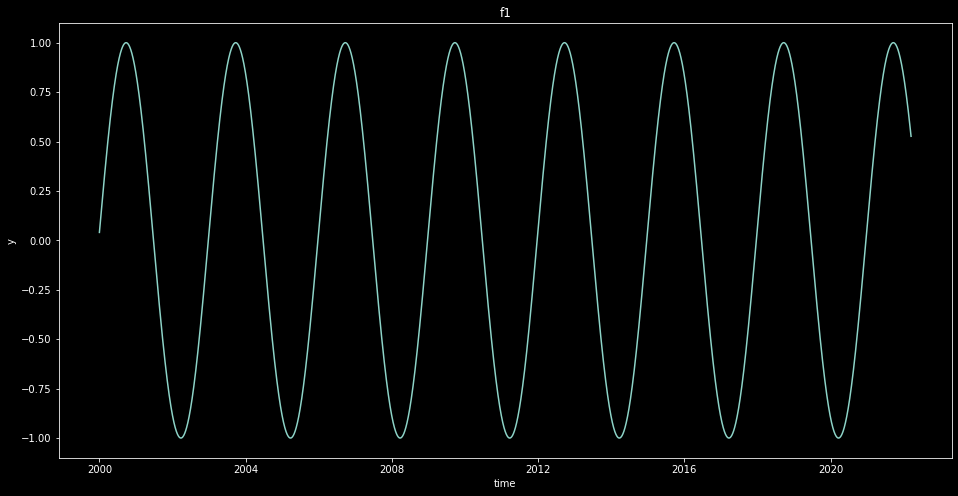

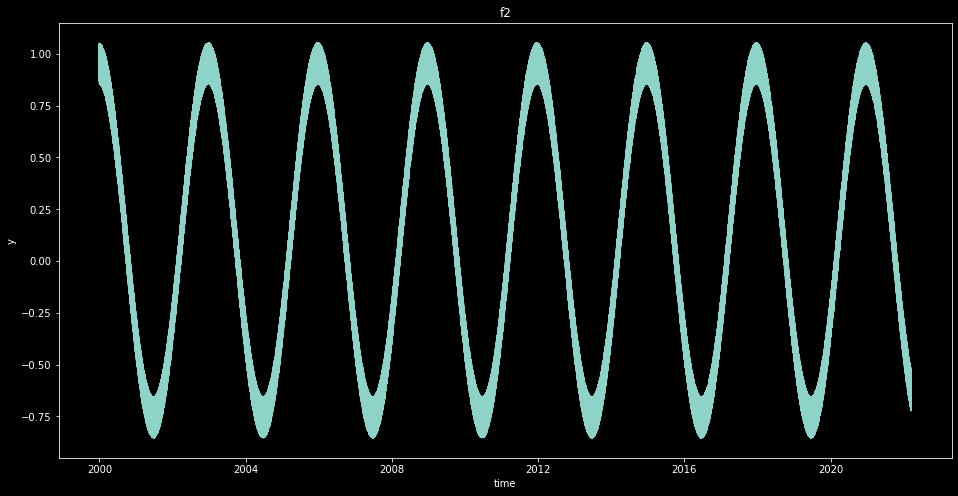

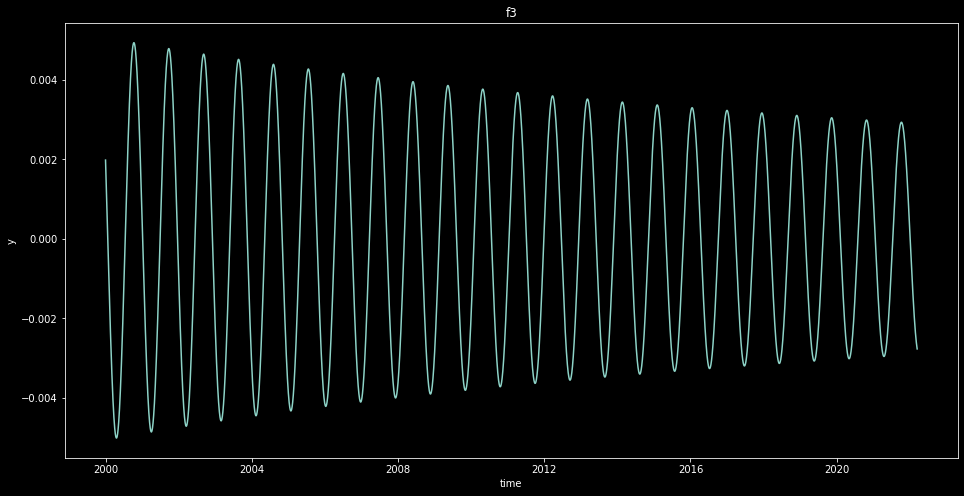

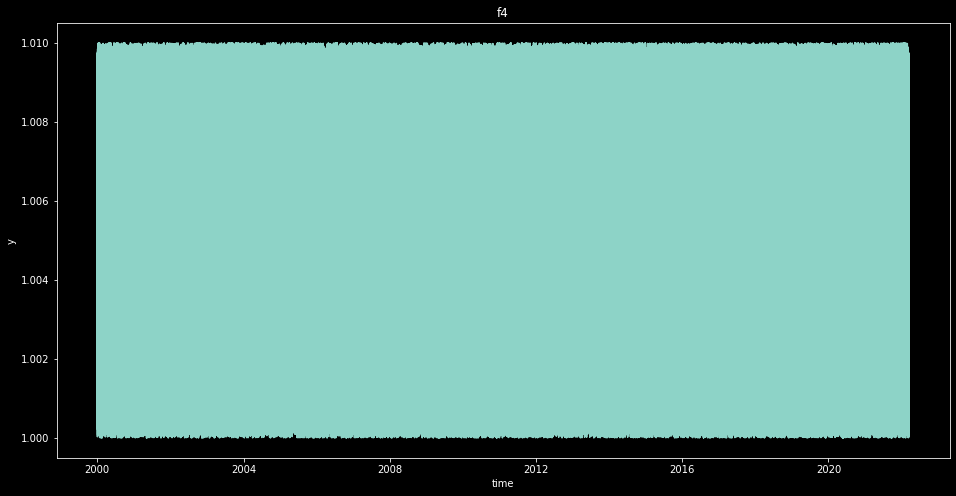

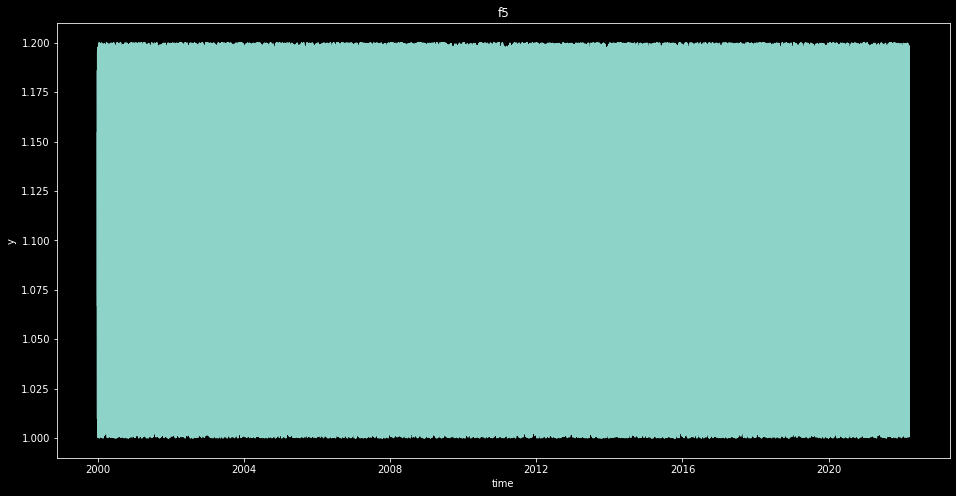

In [8]:
for i in range(len(data)):

    fig, ax = plt.subplots(figsize=(16, 8))

    ax.set_xlabel("time")
    ax.set_ylabel("y")
    ax.set_title(f"f{i+1}")

    plt.plot(t, df[f"f{i+1}"])

In [46]:
%mkdir data
df.index.name = "date"
df.to_csv("data/data.csv")

mkdir: data: File exists


In [24]:
from azure.ml import MLClient
from azure.ml.entities import Dataset, CommandJob, JobInput, Environment
from azure.ml.entities._assets.environment import BuildContext
from azure.identity import InteractiveBrowserCredential

In [15]:
subscription_id = "6560575d-fa06-4e7d-95fb-f962e74efd7a"
resource_group = "cody-dev"
workspace = "main-eg"

In [16]:
c = MLClient(
    InteractiveBrowserCredential(), subscription_id, resource_group, workspace
)
c

MLClient(credential=<azure.identity._credentials.browser.InteractiveBrowserCredential object at 0x13e57f640>,
         subscription_id=6560575d-fa06-4e7d-95fb-f962e74efd7a,
         resource_group_name=cody-dev,
         workspace_name=main-eg)

In [47]:
ds = Dataset(
    local_path="data",
    name="synthetic",
    version="3",
    description="Synthetic data for mldrift demo.",
)

c.create_or_update(ds)

Creating or updating dataset
Uploading data:   0%|          | 0.00/23.1M [00:02<?, ?B/s]


Dataset({'paths': [<azure.ml._restclient.v2021_10_01.models._models_py3.UriReference object at 0x13e6802b0>], 'is_anonymous': False, 'auto_increment_version': False, 'name': 'synthetic', 'description': 'Synthetic data for mldrift demo.', 'tags': {}, 'properties': {}, 'id': '/subscriptions/6560575d-fa06-4e7d-95fb-f962e74efd7a/resourceGroups/cody-dev/providers/Microsoft.MachineLearningServices/workspaces/main-eg/datasets/synthetic/versions/3', 'base_path': './', 'creation_context': <azure.ml._restclient.v2021_10_01.models._models_py3.SystemData object at 0x13e6800d0>, 'serialize': <msrest.serialization.Serializer object at 0x13e5b3730>, 'version': '3', 'local_path': None})

In [39]:
%rm -r data

In [56]:
start = "2022-01-01"

command = f"python main.py --data ${{inputs.data}}/data.csv --date {start}"
environment = Environment(build=BuildContext(local_path="docker-context"))
ds_input = JobInput(dataset="synthetic:3")
compute = "cpu-cluster"
experiment_name = "mldrift-synthetic-test"
display_name = "test"

environment_variables = {"AZUREML_COMPUTE_USE_COMMON_RUNTIME": "true"}

job = CommandJob(
    code_local_path="src",
    command=command,
    inputs={"data": ds_input},
    environment=environment,
    compute=compute,
    display_name=display_name,
    experiment_name=experiment_name,
    description="mldrift demo",
    environment_variables=environment_variables,
)

In [57]:
run = c.create_or_update(job)
print(run.services["Studio"].endpoint)

Creating or updating job
Uploading src:   0%|          | 0.00/1.11k [00:00<?, ?B/s]
Use of {} for parameters is deprecated, instead use ${{}}.


https://ml.azure.com/runs/ae03eb47-3b9f-4b6a-8bbf-17c841f19913?wsid=/subscriptions/6560575d-fa06-4e7d-95fb-f962e74efd7a/resourcegroups/cody-dev/workspaces/main-eg&tid=72f988bf-86f1-41af-91ab-2d7cd011db47


In [ ]:
environment = Environment(build=BuildContext(local_path="docker-context"))
ds_input = JobInput(dataset="synthetic:3")
compute = "cpu-cluster"
experiment_name = "mldrift-synthetic-test"

environment_variables = {"AZUREML_COMPUTE_USE_COMMON_RUNTIME": "true"}


start = "2000-02-01"

while start < datetime.now():

    display_name = start
    command = f"python main.py --data ${{inputs.data}}/data.csv --date {start}"

    job = CommandJob(
        code_local_path="src",
        command=command,
        inputs={"data": ds_input},
        environment=environment,
        compute=compute,
        display_name=display_name,
        experiment_name=experiment_name,
        description="mldrift demo",
        environment_variables=environment_variables,
    )

    run = c.create_or_update(job)

print(run.services["Studio"].endpoint)